# Convergence of degree distribution under addition-deletion processes

We know that an addition-deletion process causes the degree distributiuon to converge over time, erasing any information about the shape of the distribution in the original network. We ncan observe this happeing by capturing the degree distribution over the process' lifetime.

In [1]:
from collections import Counter
from scipy.stats import chisquare
from mpmath import gammainc
from numpy.random import default_rng, shuffle
from numpy import exp
from pandas import DataFrame
from networkx import degree_histogram, fast_gnp_random_graph
from epyc import ParallelLab, HDF5LabNotebook, Experiment
from epydemic import ERNetwork, PLCNetwork, Process, AddDelete, NetworkStatistics, ProcessSequence, StochasticDynamics
from epydemic.gf import *

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt
from matplotlib import colormaps

## Theoretical distribution

The theoretical understanding of addition-deletion processes is mainly due to Moore, Ghosal, and Newman. They derived an equation for the degree distribution using a method called generating functions. Without going into the method, we can capture their result and transcribe it into code.

In [2]:
def gf_add_delete(c):
    '''Construct  the generating function of an addition-deletion process
    that adds nodes with a single fixed degree.

    :param c: the degree of new nodes
    :returns: the generating function'''
    
    # constant terms from the gf can be pre-computed
    norm = pow(c, -(c + 1))
    corr = gammainc(c + 1, c)
    
    def series(z):
        if z == 1:
            z = 1 - 1e-8    # avoid a division by zero

        # the definitions of gamma functions differ between packages,
        # and specifically between mpmath (used here) and scipy.special
        # See https://mpmath.org/doc/current/functions/expintegrals.html
        return (exp(c * z) / (1 - z)) * norm * (gammainc(c + 1, c * z) - corr)

    return gf_from_series(series)

We can then plot the expected degree distribution.

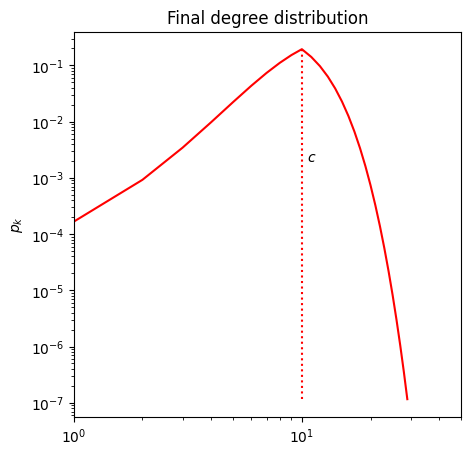

In [12]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

c = 10
ks = range(1, 30)

# theoretical
gf = gf_add_delete(c)
pks = list(map(lambda k: gf[k], ks))
plt.plot(ks, pks, 'r-', label='theoretical')

ax.plot([c, c], [min(pks), max(pks)],
        color='red', linestyle='dotted')
ax.annotate('$c$', [c, max(pks)],
            [c * 1.05, max(pks) / 100])

ax.set_xlim([1, 50])
ax.set_ylabel('$p_k$')
ax.loglog()
ax.set_title('Final degree distribution')

_ = plt.show()

The claim is that the degree distribution of *any* initial network will converge under the addition-deletion process to this distribution.

## Observing the convergence

Let's check this claim in the case of ER networks.

We first need a way to sample the degree distribution of a network as the addition-deletion proceeds. This is quite a complicated process in itself: essentially we want to capture the network statistics. `epydemic` has a class `NetworkStatistics` that does this for the end-state of a process, and we can define a new process that does a similar thing at regular intervals, using the same approach as `Monitor`.

In [13]:
class SampleDistribution(Process):
    '''A process that periodically snapshots the degree distribution of
    a network under the influence of an adaptive process. This allows
    us to study the way the degree distribution changes over time.
    
    Since each sample is stored as an array, each sample will be as large
    as the maximum degree of the network at the point the sample is taken.
    This could be large for some topologies.
    
    .. warning::
    
       Be careful not to over-sample! It's easy to collect far too much
       data. Alternatively, sub-class the :meth:`sample` method to perform
       some analysis rather than storing the degree distribution.
    '''
    
    # Parameters
    DELTA = 'epydemic.sample_kdist.time_delta'

    # Results
    OBSERVATIONS = 'epydemic.sample_kdist.observations'
    DISTRIBUTION_STEM = 'epydemic.sample_kdist.k_distribution'   
        
    @staticmethod
    def distributionAtTime(t):
        '''Return the result used to represent the degree
        distribution at the given time,
        
        :param t: the time
        :returns: a result tag'''
        return '{stem}-{t}'.format(stem=SampleDistribution.DISTRIBUTION_STEM, t=t)
            
    def reset(self):
        '''Reset the process.'''
        super().reset()
        self._kdists = []
        self._observations = []
        
    def atEquilibrium(self, t):
        '''This process is always ready to terminate.
        
        :returns: True'''
        return True
    
    def build(self, params):
        '''Build the process, adding sample events at the interval
        specified in the :attr:`DELTA` parameter.
        
        :param params: experimental parameters'''
        super().build(params)
        
        delta = params[self.DELTA]
        self.postRepeatingEvent(0.0, delta, None, self.sample)
        
    def sample(self, t, e):
        '''Sample the distribution of the network.
        
        :param t: the simulation time
        :param e: an element of the network (unused)'''
        g = self.network()
        self._observations.append(t)
        self._kdists.append(degree_histogram(g))
        
    def results(self):
        '''Construct results that include the times at which observations
        were taken (in :attr:`OBSERVATIONS`) and the sequence of observations
        themselves, with names constructed by :meth:`distributionAtTime`.
        
        :returns: the experimental results dict'''
        res = super().results()
        for i in range(len(self._observations)):
            t = self._observations[i]
            res[SampleDistribution.distributionAtTime(t)] = self._kdists[i]
        res[self.OBSERVATIONS] = self._observations
        return res

We can then combine this observational process with our addition-deletion process to observe its effects.

In [14]:
def createER(lab):
    reps = 10
        
    # create the add-delete process
    process = AddDelete()
    process.setMaximumTime(160000)
    
    # create parameter space
    lab[ERNetwork.N] = N
    lab[ERNetwork.KMEAN] = kmean
    lab[AddDelete.P_ADD] = 1
    lab[AddDelete.P_DELETE] = 1
    lab[AddDelete.DEGREE] = c
    lab['repetitions'] = range(reps)
    lab[SampleDistribution.DELTA] = 20000
        
    # run experiment
    e = StochasticDynamics(ProcessSequence([SampleDistribution(), process, NetworkStatistics()]), ERNetwork())
    lab.runExperiment(e)

In [15]:
lab = ParallelLab(HDF5LabNotebook('../../datasets/10-06-add-delete-times.h5'), cores=8)
nb = lab.notebook()

In [16]:
N = 50000
kmean = 20
c = 10 

In [17]:
lab.createWith('er', createER)

True

Having performed the simulation, we now need to visualise the results. We first define a function that turns a degree distribution into a table with degrees as columns. Each row is a network and contains the fraction of the network's nodes having the given degree.

In [18]:
def distributionAtTime(df, t):
    '''Create a DataFrame with degrees as columns.'''
    kdists = df[SampleDistribution.distributionAtTime(t)]
    
    # turn arrays into a table with one column per degree
    maxk = -1
    ls = []
    for i in range(len(kdists)):
        r = kdists.iloc[i]
        ls.append(r)
        maxk = max(maxk, len(r))
    oks = DataFrame(ls, columns=[f'{k}' for k in range(maxk)])
    
    # turn degrees into probabilities (fractions of population)
    oks['N'] = oks.sum(axis=1)
    for i in range(len(kdists)):
        oks.iloc[i] /= oks.iloc[i]['N']
    pks = oks.drop('N', axis=1)
    
    return pks, maxk

We now plot the observed degree distribution at different times, and see how the shape of the distribution curve changes over time. Eventually it converges to the theoretical distribution as predicted.

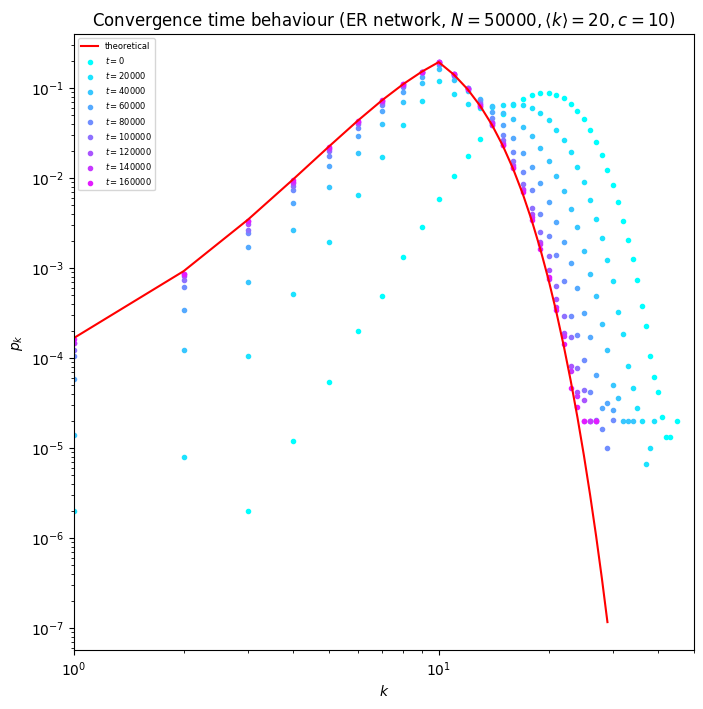

In [28]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

ks = range(1, 30)

# theoretical
gf = gf_add_delete(c)
ax.plot(ks, list(map(lambda k: gf[k], ks)), 'r-', label='theoretical')

# empirical
colourMap = colormaps['cool']
nb.select('er')
df = lab.dataframe()
ots = df.iloc[0][SampleDistribution.OBSERVATIONS]  # all at the same points
for i in range(len(ots)):
    t = ots[i]
    pks, maxk = distributionAtTime(df, t)
    
    # plot observed data
    pkmean, pkerr = pks.mean(), pks.std()
    col = colourMap(i / len(ots))
    ax.scatter(list(range(maxk)), list(pkmean),
               marker='.', color=col,
               label=f'$t = {t:.0f}$')

ax.set_xlabel('$k$')
ax.set_xlim([1, 50])
ax.set_ylabel('$p_k$')
ax.legend(loc='upper left', prop={'size': 6})
ax.loglog()
ax.set_title(f'Convergence time behaviour (ER network, $N = {N}, \\langle k \\rangle = {kmean}, c = {c}$)')

_ = plt.show()

By 16,000 timesteps the distribution has converged, destroying any information from the original network. The implication is that you can't tell what the original distribution was.

It would be interesting to explore whether the same effects are observed for the powerlaw distribution, where there are nodes with very high degree &ndash; and therefore a lot of information to destroy. This would be a large experiment probably requiring a long run-time while the addition-deletion process did its work.

## References

Moore, Ghosal, and Newman. [Exact solutions for models of evolving networks with addition and deletion of nodes](https://doi.org/10.1103/PhysRevE.74.036121). Physical Review E **74**. 2006.